<a href="https://colab.research.google.com/github/mazinkamal134/DS_MRP_2024/blob/main/GLMM/Data%20Pipeline/GLMM_Data_Pipeline_Anxiety.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: Stress score majority voting will not be used in establishing the relationship between listening to music and alleviating symptoms. It's kept here for reference only ...

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Global Params

In [ ]:
# directories
tensiDir = r"/content/drive/MyDrive/Master-2024/MRP/Data/Tweets"
tweetsDir = r"/content/drive/MyDrive/MRP/Mazin_Works/Project Docs/Data/Tweets"
demographicDir = r"/content/drive/MyDrive/Master-2024/MRP/Data/Demographics"

### Ingest & Process the data

In [ ]:
tweetsDf = pd.read_pickle(os.path.join(tensiDir, "anxietyFullWithTensiScore.pickle"))
print("Ingested file shape:", tweetsDf.shape)

Ingested file shape: (3346488, 28)


In [ ]:
# Create the pool of music sessions
musicPoolDf = tweetsDf[tweetsDf.music_id > 0].sort_values(by = ["author_id", "created_at"]).reset_index()
print("Music pool shape:", musicPoolDf.shape)

Music pool shape: (9777, 29)


In [ ]:
# Remove the treatment/diagnosis tweets and any tweet without tensi score
tweetsDf = tweetsDf[#(tweetsDf.tweet_type == "timeline") &
                    (tweetsDf.stress_score.notna()) &
                    (tweetsDf.lang == "en") &
                    (tweetsDf.cleaned_text.notna()) &
                    (tweetsDf.author_since.notna())]
print("Filtered file shape:", tweetsDf.shape)
# Group by group and find the unique authors per each group
tweetsDf.groupby("group")["author_id"].nunique().reset_index()

Filtered file shape: (2007548, 28)


,group,author_id
0,0,966
1,1,468


### Create the Tweets Pool
- Run when necessary only. This pool was already created

In [ ]:
# Create an empty DataFrame with the same schema as anxietyTweetsDf
containerDf = tweetsDf.iloc[0: 0].copy()

# Exclusion list for control users/authors
controlTweets = set()

# Loop through the music sessions and capture the eligible tweets
for index, row in tqdm(musicPoolDf.iterrows(), total = musicPoolDf.shape[0]):
#for index, row in musicPoolDf.iterrows():
    # Get the search parameters
    musicId = row["music_id"]
    authorId = row["author_id"]
    # Start date for search
    treatmentDate = row["created_at"]
    # Upper bound for search - 24 hour window
    upperDateBound = treatmentDate + pd.Timedelta(days = 1)
    # A slack variable, where the window will be extended to 48 hours if no tweets were found in the 24 hours window
    upperDateBoundSlack = treatmentDate + pd.Timedelta(days = 2)

    # Find all records 24 hours after music session (treatment)
    treatmentDf = tweetsDf[
        (tweetsDf.author_id == authorId) &
        (tweetsDf.created_at > treatmentDate) &
        (tweetsDf.created_at <= upperDateBound)
    ]

    if treatmentDf.empty:
        #print(f"No tweets found for treatment user {authorId} with music id {musicId} between {treatmentDate} and {upperDateBound}")
        continue

    treatmentDf.loc[treatmentDf.index, "music_id"] = musicId
    #print(f"Treatment user {authorId}, with music Id: {musicId}, and total {treatmentDf.shape[0]} tweets.")

    # Find a corresponding control user within 24 hours
    controlDf = tweetsDf[
        (tweetsDf.group == 0) &
        (tweetsDf.created_at > treatmentDate) &
        (tweetsDf.created_at <= upperDateBound) &
        (tweetsDf.cleaned_text.notna()) &
        (~tweetsDf.id.isin(controlTweets))
    ].groupby("author_id")["id"].count().reset_index()

    # If no control tweets are found, extend to 48 hours
    if controlDf.empty:
        #print("No matching control user in the 24 hours window was found, using the 48 hours window ...")
        controlDf = tweetsDf[
            (tweetsDf.group == 0) &
            (tweetsDf.created_at > treatmentDate) &
            (tweetsDf.created_at <= upperDateBoundSlack) &
            (tweetsDf.cleaned_text.notna()) &
            (~tweetsDf.id.isin(controlTweets))
        ].groupby("author_id")["id"].count().reset_index()

    if controlDf.empty:
        #print("No matching control user was found, skipping both ...")
        continue

    # Select the control user with the max tweets
    # controlUser = controlDf.sort_values(by = "id", ascending=False).iloc[0]["author_id"]
    # To avoid the selection bias, let's choose randomally
    controlUser = controlDf.sample(1)["author_id"].item()


    # Get the tweets for the selected control user
    controlTweetsDf = tweetsDf[
        (tweetsDf.author_id == controlUser) &
        (tweetsDf.created_at > treatmentDate) &
        (tweetsDf.created_at <= upperDateBoundSlack) &
        (tweetsDf.cleaned_text.notna())
    ]
    # Add the user control tweets to the exclusion list
    controlTweets.update(controlTweetsDf.id.values)
    # Add the music ids to link to the treatment tweets
    controlTweetsDf.loc[controlTweetsDf.index, "music_id"] = musicId

    #print(f"Control user {controlUser}, with music Id: {musicId}, and total {controlTweetsDf.shape[0]} tweets.")

    # Combine all dataframes into one
    containerDf = pd.concat([containerDf, treatmentDf, controlTweetsDf], ignore_index = True)

100%|██████████| 9777/9777 [1:42:49<00:00,  1.58it/s]


In [ ]:
# Pickle the file
print("Shape of the pool data:", containerDf.shape)
filePath = os.path.join(tweetsDir, "anxietyTweetsPoolDf.pickle")
with open(filePath, 'wb') as f:
    pickle.dump(containerDf, f)

Shape of the pool data: (306472, 28)


In [ ]:
# # Read the pickle - whenever needed
# filePath = os.path.join(tweetsDir, "anxietyTweetsPoolDf.pickle")
# containerDf = pd.read_pickle(filePath)
# print("Shape:", containerDf.shape)

In [ ]:
# Fill NA on stress_Score
containerDf["stress_score"] = containerDf["stress_score"].fillna(0)
# Introduce a new binary score
containerDf["stress_score_binary"] = containerDf["stress_score"].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
containerDf.dropna(inplace = True)
containerDf.shape

(306472, 29)

In [ ]:
# Majority voting
def majority_vote_with_tie_breaker(group):
    modeResult = group.mode()
    if len(modeResult) > 1:  # Tie exists
        return 1
    else:
        return modeResult[0]

# Customize the original dataframe
majorityVotingDf = containerDf[["author_id", "music_id", "group", "stress_score_binary"]]

# Group and apply the function
majorityVotingDf = majorityVotingDf.groupby(["author_id", "music_id", "group"]).agg(
    stress_score = ("stress_score_binary", majority_vote_with_tie_breaker)
).reset_index().sort_values(by = ["author_id", "music_id"])

# Add surrogate key
majorityVotingDf["author_music_id"] = majorityVotingDf["author_id"] + '_' + majorityVotingDf["music_id"].astype(str)
# Finalize the dataframe
majorityVotingDf = majorityVotingDf[["author_id", "music_id", "author_music_id", "group", "stress_score"]]

# Check
print("Shape:", majorityVotingDf.shape)
majorityVotingDf.sample(5)

Shape: (17426, 5)


,author_id,music_id,author_music_id,group,stress_score
15291,843850790204772356,28877.0,843850790204772356_28877.0,0,0
5291,1285280184304836608,28146.0,1285280184304836608_28146.0,0,0
3731,1195574926096384000,25056.0,1195574926096384000_25056.0,1,1
4579,1252781082,29892.0,1252781082_29892.0,0,1
7468,141931511,29325.0,141931511_29325.0,0,0


In [ ]:
# Save to parquet
filePath = os.path.join(tweetsDir, "anxietyTweetsPoolDf_majorityVoting.parquet")
majorityVotingDf.to_parquet(filePath)

### Distributions

##### Majority Voting

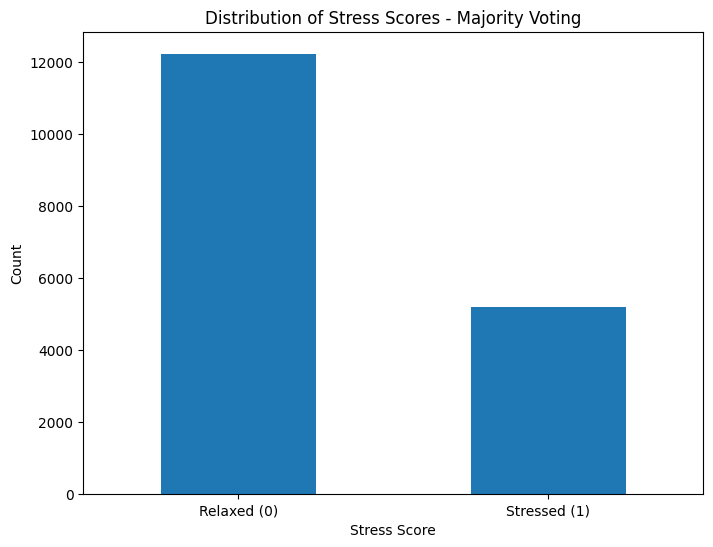

In [ ]:
# Plotting the distribution
plt.figure(figsize = (8, 6))  # Adjust figure size as needed
majorityVotingDf["stress_score"].value_counts().plot(kind = "bar")
plt.title("Distribution of Stress Scores - Majority Voting")
plt.xlabel("Stress Score")
plt.ylabel("Count")
plt.xticks([0, 1], ["Relaxed (0)", "Stressed (1)"], rotation = 0)
plt.show()

In [ ]:
# Calculate the probability of success
p = majorityVotingDf["stress_score"].mean()  # probability of success
# Use bionomial test to check the goodness of fit
result = stats.binomtest(sum(majorityVotingDf["stress_score"]), len(majorityVotingDf["stress_score"]), p)
# Output the result

print(f"Binomial test statistic: {result.statistic}")
print(f"P-value: {result.pvalue}")

# Interpret the result
if result.pvalue > 0.05:
    print("Fail to reject the null hypothesis: The distribution is Bernoulli.")
else:
    print("Reject the null hypothesis: The distribution is not Bernoulli.")

Binomial test statistic: 0.2977734419832434
P-value: 1.0
Fail to reject the null hypothesis: The distribution is Bernoulli.


In [ ]:
# Calculate the probability of success
p = majorityVotingDf["stress_score"].mean()
print(f"probability of success: {p}")

# Observed frequencies
observedCounts = np.bincount(majorityVotingDf["stress_score"])
observedFreq = observedCounts / len(majorityVotingDf["stress_score"])

# Expected frequencies
expectedFreq = np.array([1 - p, p])

# chi-squared test
chi2Stat, pValue = stats.chisquare(observedFreq, expectedFreq)

print(f"Chi-squared statistic: {chi2Stat}")
print(f"P-value: {pValue}")

# Interpret the result
if pValue > 0.05:
    print("Fail to reject the null hypothesis: The distribution is Bernoulli.")
else:
    print("Reject the null hypothesis: The distribution is not Bernoulli.")

probability of success: 0.2977734419832434
Chi-squared statistic: 0.0
P-value: 1.0
Fail to reject the null hypothesis: The distribution is Bernoulli.


##### Average Score

In [ ]:
# read the pooling dataset
containerDf = pd.read_pickle(os.path.join(tweetsDir, "anxietyTweetsPoolDf.pickle"))
containerDf.dropna(inplace = True)
print("Ingested file shape:", containerDf.shape)

Ingested file shape: (306472, 28)


In [ ]:
# Customize the original dataframe
avgScoreDf = containerDf[["author_id", "music_id", "group", "stress_score"]]

# Group by and apply the mean function
avgScoreDf = avgScoreDf.groupby(["author_id", "music_id", "group"])["stress_score"].mean().reset_index().sort_values(by = ["author_id", "music_id"])

# Add surrogate key
avgScoreDf["author_music_id"] = avgScoreDf["author_id"] + '_' + avgScoreDf["music_id"].astype(str)
avgScoreDf = avgScoreDf[["author_id", "music_id", "author_music_id", "group", "stress_score"]]

# Check
print("Shape:", avgScoreDf.shape)
avgScoreDf.sample(5)

Shape: (17426, 5)


,author_id,music_id,author_music_id,group,stress_score
996,1029965043495038976,26998.0,1029965043495038976_26998.0,1,0.542857
2530,1095410398348615683,28481.0,1095410398348615683_28481.0,0,1.000000
3308,1154136258144342016,26088.0,1154136258144342016_26088.0,0,1.055556
739,1029965043495038976,26741.0,1029965043495038976_26741.0,1,0.600000
16013,887648194603212800,25555.0,887648194603212800_25555.0,1,0.500000


In [ ]:
# Save to parquet
filePath = os.path.join(tweetsDir, "anxietyTweetsPoolDf_avgScore.parquet")
avgScoreDf.to_parquet(filePath)

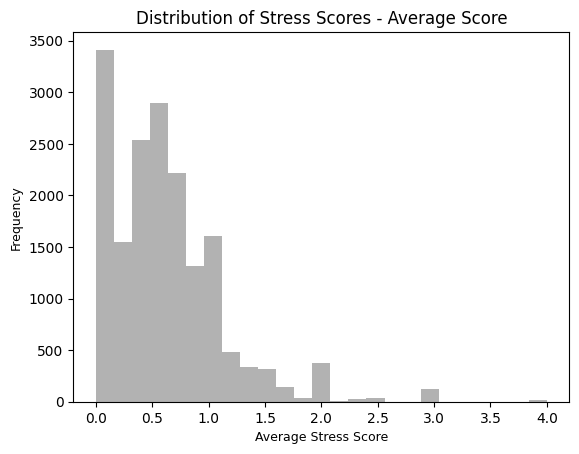

In [ ]:
# Visual inspection of the distribution (all)
plt.hist(avgScoreDf["stress_score"], bins = 25, color = "gray", alpha = 0.6, label = "avg. Stress Score")
#sns.histplot(data=avgScoreDf, x='stress_score', element='step', bins=25, palette="Set2", kde=True, legend=True, color="gray")
plt.title("Distribution of Stress Scores - Average Score", size = 12)
plt.xlabel("Average Stress Score", size = 9)
plt.ylabel("Frequency", size = 9)
plt.show()

<ipython-input-33-088ae25a066b>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=[x for x in avgScoreDf["stress_score"].values if x != 0], element='step', bins = 25, palette="Set2", kde=True, legend=True)


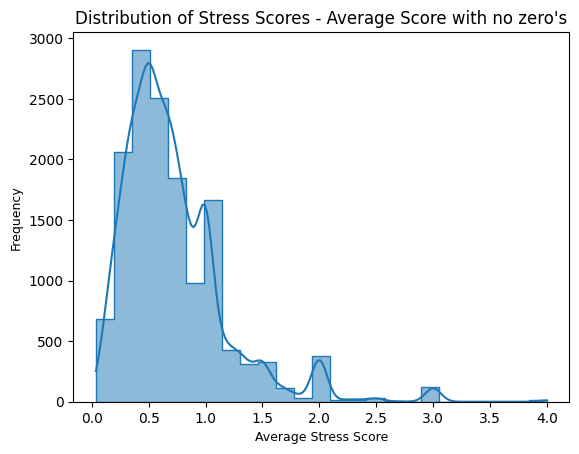

In [ ]:
# Visual inspection of the distribution (remove 0's)
#plt.hist([x for x in avgScoreDf["stress_score"].values if x != 0], bins = 25, alpha = 0.6, label = "avg. Stress Score")
sns.histplot(data=[x for x in avgScoreDf["stress_score"].values if x != 0], element='step', bins = 25, palette="Set2", kde=True, legend=True)
plt.title("Distribution of Stress Scores - Average Score with no zero's", size = 12)
plt.xlabel("Average Stress Score", size = 9)
plt.ylabel("Frequency", size = 9)
plt.show()

##### Gamma

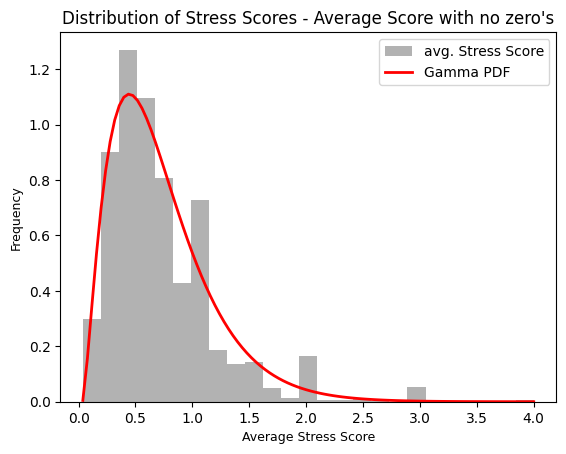

Proportion of zeros: 0.17152530701251004
Gamma fit for non-zeros (p-value): 1.0177429051710696e-64
KS-statistic: 0.07155223501250618
Reject the null hypothesis: The distribution is not Gamma.


In [ ]:
# Data
data = avgScoreDf["stress_score"].values

# Separate zeros and non-zeros
zeros = [x for x in data if x == 0]
nonZeros = [x for x in data if x != 0]

# Estimate Gamma parameters (for non-zero values)
shape, loc, scale = stats.gamma.fit(nonZeros)

# Perform Kolmogorov-Smirnov test on non-zero values
statistic, pValue = stats.kstest(nonZeros, 'gamma', args=(shape, loc, scale))

# Plot histogram and PDF
plt.hist(nonZeros, bins=25, color="gray", density=True, alpha = 0.6, label = "avg. Stress Score")
x = np.linspace(min(nonZeros), max(nonZeros), 100)
plt.plot(x, stats.gamma.pdf(x, shape, loc, scale), "r-", lw = 2, label = 'Gamma PDF')
plt.title("Distribution of Stress Scores - Average Score with no zero's", size = 12)
plt.xlabel("Average Stress Score", size = 9)
plt.ylabel("Frequency", size = 9)
plt.legend()
plt.show()

# Print results (example interpretation)
print(f"Proportion of zeros: {len(zeros) / len(data)}")
print(f"Gamma fit for non-zeros (p-value): {pValue}")
print(f"KS-statistic: {statistic}")

# Interpret the result
if pValue > 0.05:
    print("Fail to reject the null hypothesis: The distribution is Gamma.")
else:
    print("Reject the null hypothesis: The distribution is not Gamma.")

##### Log-normal

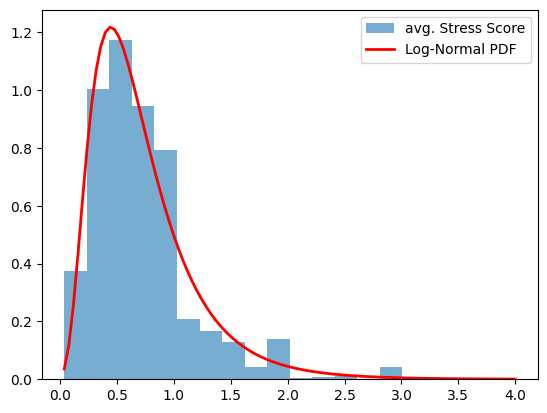

Proportion of zeros: 0.17152530701251004
Log-Normal fit for non-zeros (p-value): 2.639344919963528e-41
KS-statistic: 0.05706442685593216
Reject the null hypothesis: The distribution is not Log-Normal.


In [ ]:
# Estimate Gamma parameters (for non-zero values)
shape, loc, scale = stats.lognorm.fit(nonZeros)

# Perform Kolmogorov-Smirnov test on non-zero values
statistic, pValue = stats.kstest(nonZeros, 'lognorm', args=(shape, loc, scale))

# Plot histogram and PDF
plt.hist(nonZeros, bins=20, density=True, alpha = 0.6, label = "avg. Stress Score")
x = np.linspace(min(nonZeros), max(nonZeros), 100)
plt.plot(x, stats.lognorm.pdf(x, shape, loc, scale), "r-", lw = 2, label = 'Log-Normal PDF')
plt.legend()
plt.show()

# Print results (example interpretation)
print(f"Proportion of zeros: {len(zeros) / len(data)}")
print(f"Log-Normal fit for non-zeros (p-value): {pValue}")
print(f"KS-statistic: {statistic}")

# Interpret the result
if pValue > 0.05:
    print("Fail to reject the null hypothesis: The distribution is Log-Normal.")
else:
    print("Reject the null hypothesis: The distribution is not Log-Normal.")

##### Exponential

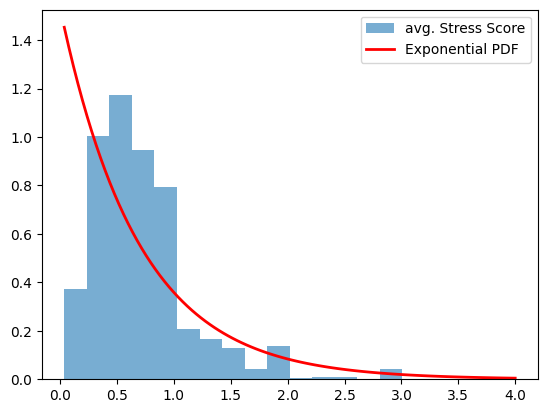

Proportion of zeros: 0.17152530701251004
Exponential fit for non-zeros (p-value): 0.0
KS-statistic: 0.20908414895221678
Reject the null hypothesis: The distribution is not Exponential.


In [ ]:
# Estimate Gamma parameters (for non-zero values)
loc, scale = stats.expon.fit(nonZeros)

# Perform Kolmogorov-Smirnov test on non-zero values
statistic, pValue = stats.kstest(nonZeros, 'expon', args=(loc, scale))

# Plot histogram and PDF
plt.hist(nonZeros, bins=20, density=True, alpha = 0.6, label = "avg. Stress Score")
x = np.linspace(min(nonZeros), max(nonZeros), 100)
plt.plot(x, stats.expon.pdf(x, loc, scale), "r-", lw = 2, label = 'Exponential PDF')
plt.legend()
plt.show()

# Print results (example interpretation)
print(f"Proportion of zeros: {len(zeros) / len(data)}")
print(f"Exponential fit for non-zeros (p-value): {pValue}")
print(f"KS-statistic: {statistic}")

# Interpret the result
if pValue > 0.05:
    print("Fail to reject the null hypothesis: The distribution is Exponential.")
else:
    print("Reject the null hypothesis: The distribution is not Exponential.")

### Add the demographic data

#### Read

In [ ]:
# Read the demographics datasets
ageDf = pd.read_pickle(os.path.join(demographicDir, "authorAge.pickle"))
genderDf = pd.read_pickle(os.path.join(demographicDir, "authorGender.pickle"))
eduLvlDf = pd.read_pickle(os.path.join(demographicDir, "authorEducationLevel.pickle"))
# Check
print("Age df shape:", ageDf.shape)
print("Gender df shape:", genderDf.shape)
print("ARI df shape:", eduLvlDf.shape)

# Combine
demographicsDf = ageDf.merge(genderDf[["author_id", "gender"]], on = "author_id", how = "left")
demographicsDf = demographicsDf.merge(eduLvlDf[["author_id", "ari_grade"]], on = "author_id", how = "left")
# Remove unnecessary columns
demographicsDf = demographicsDf[["author_id", "age_group", "gender", "ari_grade"]]
# Rename ari_grade_binary to edu_level
demographicsDf.rename(columns = {"ari_grade": "edu_level"}, inplace = True)
# Check
print("Demographics df shape:", demographicsDf.shape)
demographicsDf.sample()

Age df shape: (5612, 30)
Gender df shape: (5612, 29)
ARI df shape: (5612, 6)
Demographics df shape: (5612, 4)


,author_id,age_group,gender,edu_level
5118,847704348339470338,Gen-Z,Male,Middle/Elemntary School


#### Majority voting

In [ ]:
# Read
majorityVotingDf = pd.read_parquet(os.path.join(tweetsDir, "anxietyTweetsPoolDf_majorityVoting.parquet"))
print("Shape:", majorityVotingDf.shape)
majorityVotingDf.sample()

Shape: (17426, 5)


,author_id,music_id,author_music_id,group,stress_score
9796,254181539,26082.0,254181539_26082.0,1,0


In [ ]:
# Use tweets df to add the demographic info to the majority voting df
majorityVotingDf = majorityVotingDf.merge(demographicsDf, on = "author_id", how = "left")
print("Shape before dropping na:", majorityVotingDf.shape)
# drop na
majorityVotingDf = majorityVotingDf.dropna()
# use label encoder to encode the values of the demographics
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
majorityVotingDf["age_group"] = le.fit_transform(majorityVotingDf["age_group"])
mapping = {index: label for index, label in enumerate(le.classes_)}
print(mapping)
majorityVotingDf["gender"] = le.fit_transform(majorityVotingDf["gender"])
mapping = {index: label for index, label in enumerate(le.classes_)}
print(mapping)
majorityVotingDf["edu_level"] = le.fit_transform(majorityVotingDf["edu_level"])
mapping = {index: label for index, label in enumerate(le.classes_)}
print(mapping)
print("Shape after dropping na:", majorityVotingDf.shape)
majorityVotingDf.sample()

Shape before dropping na: (17426, 8)
{0: 'Gen-Z', 1: 'Millenial'}
{0: 'Female', 1: 'Male'}
{0: 'High School & College', 1: 'Middle/Elemntary School'}
Shape after dropping na: (17426, 8)


,author_id,music_id,author_music_id,group,stress_score,age_group,gender,edu_level
1394,1029965043495038976,27397.0,1029965043495038976_27397.0,1,0,1,0,1


In [ ]:
# Save to parquet
filePath = os.path.join(tweetsDir, "anxietyTweetsPoolDf_majorityVoting_demographics.parquet")
majorityVotingDf.to_parquet(filePath)

#### Avg. Score

In [ ]:
# Read
avgScoreDf = pd.read_parquet(os.path.join(tweetsDir, "anxietyTweetsPoolDf_avgScore.parquet"))
print("Shape:", avgScoreDf.shape)
avgScoreDf.sample()

Shape: (17426, 5)


,author_id,music_id,author_music_id,group,stress_score
17090,972085610109321216,24353.0,972085610109321216_24353.0,0,0.625


In [ ]:
# Use tweets df to add the demographic info to the majority voting df
avgScoreDf = avgScoreDf.merge(demographicsDf, on = "author_id", how = "left")
print("Shape before dropping na:", majorityVotingDf.shape)
# drop na
avgScoreDf = avgScoreDf.dropna()
# use label encoder to encode the values of the demographics
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
avgScoreDf["age_group"] = le.fit_transform(avgScoreDf["age_group"])
mapping = {index: label for index, label in enumerate(le.classes_)}
print(mapping)
avgScoreDf["gender"] = le.fit_transform(avgScoreDf["gender"])
mapping = {index: label for index, label in enumerate(le.classes_)}
print(mapping)
avgScoreDf["edu_level"] = le.fit_transform(avgScoreDf["edu_level"])
mapping = {index: label for index, label in enumerate(le.classes_)}
print(mapping)
print("Shape after dropping na:", avgScoreDf.shape)
avgScoreDf.sample()

Shape before dropping na: (17426, 8)
{0: 'Gen-Z', 1: 'Millenial'}
{0: 'Female', 1: 'Male'}
{0: 'High School & College', 1: 'Middle/Elemntary School'}
Shape after dropping na: (17426, 8)


,author_id,music_id,author_music_id,group,stress_score,age_group,gender,edu_level
656,1028675071727030274,30266.0,1028675071727030274_30266.0,0,0.285714,0,0,1


In [ ]:
# Save to parquet
filePath = os.path.join(tweetsDir, "anxietyTweetsPoolDf_avgScore_demographics.parquet")
avgScoreDf.to_parquet(filePath)